In [6]:
!pip install livelossplot;
!pip install torchsummary;
!pip install torchvision;
import math;
from inspect import isfunction;
from functools import partial;

%matplotlib inline
import matplotlib.pyplot as plt;
#from einops import rearrange

import torch;
import torch.nn as nn;
import torch.nn.functional as F;
import torchvision;
import numpy as np;
from torchvision import transforms;
from livelossplot import PlotLosses;
from torchvision import transforms;
from torchvision.utils import make_grid;


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: C:\Users\20210826\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: C:\Users\20210826\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: C:\Users\20210826\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [36]:
import math
import random
from inspect import isfunction
from functools import partial

# %matplotlib inline
# import matplotlib.pyplot as plt
# from tqdm.auto import tqdm
# from einops import rearrange

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
from torchvision import transforms


# https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial9/AE_CIFAR10.html

class Encoder(nn.Module):

    def __init__(self,
                 num_input_channels: int,
                 base_channel_size: int,
                 latent_dim: int):
        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2),
            nn.GELU(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv2d(c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2),
            nn.GELU(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2),
            nn.ReLU(),
            nn.Flatten(), # nn.GELU()
            nn.Linear(2 * 16 * c_hid, latent_dim)
        )

    def forward(self, x):
        return self.net(x)


class Decoder(nn.Module):

    def __init__(self,
                 num_input_channels: int,
                 base_channel_size: int,
                 latent_dim: int):
        super().__init__()
        c_hid = base_channel_size
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 2 * 16 * c_hid),
            nn.GELU()
        )
        self.net = nn.Sequential(
            nn.ConvTranspose2d(2 * c_hid, 2 * c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),
            nn.GELU(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
            nn.GELU(),
            nn.ConvTranspose2d(2 * c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),
            nn.GELU(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=0),
            nn.GELU(),
            nn.ConvTranspose2d(c_hid, num_input_channels, kernel_size=3, output_padding=1, padding=1, stride=2),
            nn.ReLU(), #nn.Tanh()
        )

    def forward(self, x):
        x = x.to(torch.float32)  # because linear layer expects float32
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.net(x)
        return x
# def Encoder(self, x):
#     # This transforms x from discrete values (0, 1, ...)
#     # to the domain (-1,1).
#     # Rounding here just a safeguard to ensure the input is discrete
#     # (although typically, x is a discrete variable such as uint8)
#     x = x.round()
#     return 2 * ((x+.5) / 1) - 1
# def Decoder(z, g_0):

#     # Logits are exact if there are no dependencies between dimensions of x
#     x_vals = jnp.arange(0, config.vocab_size)[:, None]
#     x_vals = jnp.repeat(x_vals, 3, 1)
#     x_vals = Encoder(x_vals).transpose([1, 0])[None, None, None, :, :]
#     inv_stdev = jnp.exp(-0.5 * g_0[..., None])
#     logits = -0.5 * jnp.square((z[..., None] - x_vals) * inv_stdev)

#     logprobs = jax.nn.log_softmax(logits)
#     return logprobs
"""
encoder = Encoder(num_input_channels=1, base_channel_size=32, latent_dim=256)
# input image
x = torch.randn(10000, 1, 28, 28)
encoder(x).shape
decoder = Decoder(num_input_channels=1, base_channel_size=32, latent_dim=256)
# input image
x = torch.randn(1000, 256)
decoder(x).shape
"""


# Measures the reconstruction loss from the encoding the image to latent space and then decoding it back to the image
def autoencoder_loss(x, x_hat):
    return F.binary_cross_entropy(x_hat,x) #F.binary_cross_entropy(x_hat, x)  # For MNIST dataset (or log prob if we get distributions)


# Latent loss
def latent_loss(x_hat):
    var_1 = sigma2(gamma(1.0))
    mean_sqr = (1. - var_1) * torch.square(x_hat)
    loss_lat = 0.5 * torch.sum(mean_sqr + var_1 - torch.log(var_1) - 1, dim=1)
    return loss_lat


def recon_loss(img, enc_img, decoder: Decoder):
    g_0 = gamma(0)
    # numpy normal distribution
    eps_0 = np.random.normal(size=enc_img.size())
    z_0 = variance_map(enc_img, g_0, eps_0)
    # rescale
    z_0_rescaled = z_0 / alpha(g_0)
    # decode
    decoded_img = decoder(z_0_rescaled)
    # make sure decoded_img is positive (change tensor sign)
    decoded_img2 = torch.where(decoded_img < 0, -decoded_img, decoded_img)  # this might be a bottleneck
    return autoencoder_loss(img, decoded_img2), decoded_img


############################################################################################################
# Diffusion process functions
############################################################################################################
# The timestep embedding is for the diffusion model to learn the temporal information of the time series
def get_timestep_embedding(timesteps, embedding_dim):
    t = timesteps
    t = t * 1000
    half_dim = embedding_dim // 2
    emb = np.log(10000) / (half_dim - 1)
    emb = np.exp(np.arange(half_dim) * -emb)
    emb = np.outer(t, emb)
    emb = np.concatenate([np.sin(emb), np.cos(emb)], axis=1)

    assert emb.shape == (t.shape[0], embedding_dim)
    return torch.from_numpy(emb).float()


# Forward diffusion process functions
def gamma(ts, gamma_min=-6, gamma_max=6):
    return gamma_max + (gamma_min - gamma_max) * ts


def sigma2(gamma_x):
    tensor = torch.tensor(gamma_x)
    return torch.sigmoid(-tensor)  # correct?


def alpha(gamma_x):
    return np.sqrt(1 - sigma2(gamma_x))


def variance_map(x, gamma_x, eps):
    return alpha(gamma_x) * x + np.sqrt(sigma2(gamma_x)) * eps


class ResNet(nn.Module):
    # Residual network
    def __init__(self, latent_dim, embed_dim, num_blocks=4, num_layers=4, activation=nn.ReLU, norm=nn.LayerNorm):
        super().__init__()
        self.latent_dim = latent_dim
        self.embed_dim = embed_dim
        self.num_blocks = num_blocks
        self.num_layers = num_layers
        self.activation = activation
        self.norm = norm

        self.blocks = nn.ModuleList()
        for _ in range(self.num_layers):
            self.blocks.append(self._make_block())

    def _make_block(self):
        # without convolutional layers
        layers = [self.norm([self.latent_dim]), self.activation(), nn.Linear(self.latent_dim, self.embed_dim)]
        return nn.Sequential(*layers)

    def forward(self, x, cond):
        z = x
        for block in self.blocks:
            h = block(z)
            if cond is not None:
                h = h + nn.Linear(cond.shape[1], self.embed_dim, bias=False)(cond)
            h = self.activation()(self.norm([self.embed_dim])(h))
            h = nn.Linear(self.embed_dim, self.latent_dim)(h)
        z = z + h
        return z


# Score neural network for the diffusion process. Approximates what you should do at each timestep
class ScoreNet(nn.Module):
    def __init__(self, latent_dim, embedding_dim, n_blocks=32):
        super().__init__()
        self.latent_dim = latent_dim
        self.embedding_dim = embedding_dim
        self.resnet = ResNet(self.embedding_dim, self.embedding_dim * 2)

    def forward(self, x, t, conditioning):
        timestep = get_timestep_embedding(t, self.embedding_dim)
        # assert conditioning.shape[0]==timestep.shape[0] #as the output of encoder is (1, encoded_dim) this condition must eb satisfied
        cond = timestep  # cond = torch.cat((timestep, conditioning), dim=1)

        cond = nn.SiLU()(nn.Linear(self.embedding_dim, self.embedding_dim * 4)(cond))
        cond = nn.SiLU()(nn.Linear(self.embedding_dim * 4, self.embedding_dim * 4)(cond))
        cond = nn.Linear(self.embedding_dim * 4, self.embedding_dim)(cond)

        h = nn.Linear(self.latent_dim, self.embedding_dim)(x)  # hardcoded but should be latent_dim
        #h = torch.reshape(h, (1, 32, 1, 1))  # Reshaped for convolutional layers
        h = self.resnet(h, cond)
        return x + h





def diffusion_loss(z_0, t, score_net, conditioning, timesteps):
    # z_0 is the initial latent variable
    # t is the time step (time steps need to be discrete)
    # z_t is the latent variable at time t
    # z_t is a function of z_0 and t

    # Eps is a random tensor with the same shape as z_0 drawn from a normal distribution
    eps = torch.randn_like(z_0)
    gamma_x = gamma(t)
    z_t = variance_map(z_0, gamma_x, eps)

    # The score function is the derivative of the latent variable with respect to time
    score = score_net(z_t, t, conditioning)
    loss_diff_mse = torch.sum((torch.square(eps - score)), dim=-1)

    # The diffusion process is a stochastic process
    T = timesteps
    s = t - (1. / T)
    g_s = gamma(s)
    loss_diff = .5 * T * np.expm1(g_s - gamma_x) * loss_diff_mse

    return loss_diff

class VariationalDiffusion(nn.Module):
    timesteps: int = 1000
    layers: int = 32
    gamma_min: float = -13 #-3.0
    gamma_max: float = 5 #3.0
    antithetic: bool = False

    def __init__(self, latent_dim, embedding_dim, n_blocks=32):
        super().__init__()
        self.latent_dim = latent_dim
        self.embedding_dim = embedding_dim
        self.score_net = ScoreNet(self.latent_dim, self.embedding_dim, n_blocks=n_blocks)
        self.encoder = Encoder(1, 128, latent_dim)
        self.decoder = Decoder(1, 128, latent_dim)

    def forward(self, img, conditioning=None):  # combined loss for diffusion and reconstruction
        # encoding image
        z_0 = self.encoder(img)
        # encoder loss
        loss_recon, recon_IMG = recon_loss(img, z_0, self.decoder)

        loss_latent = latent_loss(z_0)

        # diffusion loss
        # we need to sample time steps
        if self.antithetic:
            orig_t = torch.rand(1)
            t = np.mod(orig_t + np.arange(0., 1., step=1. / img.shape[0]), 1.0)
            # turn to float32
            t = t.to(torch.float32)
            t = torch.reshape(t, (img.shape[0], 1))
        else:
            t = torch.rand((img.shape[0], 1))

        # discretize time steps
        t = np.ceil(t * self.timesteps) / self.timesteps
        loss_diff = diffusion_loss(z_0, t, self.score_net, conditioning, self.timesteps)
        scale= torch.div(1,(torch.prod(torch.tensor(img.shape[1:]))*np.log(2)))
        out=torch.mul(torch.mean(loss_recon)*1000+ torch.mean(loss_latent)*1000000 + torch.mean(loss_diff), scale)
        return out,  (torch.mean(loss_recon)*scale*1000, torch.mean(loss_latent)*scale*1000000, torch.mean(loss_diff)*scale), recon_IMG
    # loss_recon, loss_latent, loss_diff#
    #
    def sample(self, z_t, step, timesteps, conditioning, guidance_weight=0.):
        eps = torch.randn_like(z_t)
        t = (timesteps - step) / timesteps
        s = (timesteps - step - 1) / timesteps

        g_s = gamma(s)
        g_t = gamma(t)

        cond = conditioning if conditioning is not None else torch.zeros_like(z_t)

        eps_hat_cond = self.score_net(z_t, g_t * torch.ones(z_t.shape[0]), cond)

        eps_hat_uncond = self.score_net(z_t, g_t * torch.ones(z_t.shape[0]), torch.zeros_like(z_t))

        eps_hat = (1. + guidance_weight) * eps_hat_cond - guidance_weight * eps_hat_uncond
        a = torch.sigmoid(torch.tensor(g_s))
        b = torch.sigmoid(torch.tensor(g_t))
        c = -np.expm1(g_t - g_s)
        sigma_t = torch.sqrt(sigma2(g_t))
        z_s = torch.sqrt(a/b) * (z_t - sigma_t * c * eps_hat) + np.sqrt((1. - a) * c) * eps
        return z_s

    def sample_from_prior(self, t, num_samples=1):
        return self.sample(t, conditioning=torch.zeros((num_samples, 0)), num_samples=num_samples)

    def sample_from_posterior(self, t, conditioning, num_samples=1):
        return self.sample(t, conditioning=conditioning, num_samples=num_samples)
    
    def recon(self, img, t ,conditioning=None, num_samples=1,timesteps=timesteps):
        z_0 = self.encoder(img)
        T = timesteps
        t_n = np.ceil(t * T)
        t = t_n / T
        g_t = gamma(t)
        eps =torch.randn((num_samples, self.latent_dim))
        # not sure about difference between
        # rng_body = jax.random.fold_in(rng, i)
        # eps = random.normal(rng_body, z_t.shape)
        # and this
        # rng, spl = random.split(rng)
        diffused = variance_map(z_0, g_t, eps)
        
        for t in range((T - t_n).astype('int'), self.timesteps):
            diffused= self.sample(z_t=diffused, step=t, timesteps=timesteps, conditioning=conditioning)
            
        g0 = gamma(0.0)
        var0 = sigma2(g0)
        z0_rescaled = diffused / np.sqrt(1.0 - var0)
        reconstructed= self.decoder(z0_rescaled)
        return reconstructed

def TrainVDM(batch_size_train, n_epochs):
    
    train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('../', train=True, download=False,
                                transform=torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor()
                                ])),batch_size=batch_size_train, shuffle=True)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    #model=VariationalDiffusion(256, 256).to(device)   
    model= VariationalDiffusion(32, 32).to(device)
    # model.load_state_dict(torch.load( "./MODEL_256_512_15")["state_dict"])
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0008, eps=1e-8, weight_decay=1e-4)
    # optimizer.load_state_dict(torch.load ("./MODEL_256_512_15")["optimizer"])
    # train_losses=torch.load ("./MODEL_256_512_15")["losslogger"]
    
    model.train()
    log_interval=300
    train_losses = []
    train_counter = []
    logs={}
    
    for epoch in range(1, n_epochs + 1):
        for batch_idx, (data, target) in enumerate(train_loader):
            
            optimizer.zero_grad()
            loss, values, IMG = model(data)
            #print(values)
            loss.backward()
            optimizer.step()
            #logs['loss'] = np.array(train_losses)
            #liveloss.update(logs)
            #liveloss.draw()
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f},{}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(),values))
                train_losses.append(loss.detach().numpy())
                train_counter.append(
                (batch_idx*1000) + ((epoch-1)*len(train_loader.dataset)))
        plt.plot(train_losses)
        plt.show()        
    state = {'epoch': epoch+1, 'state_dict': model.state_dict(),'optimizer': optimizer.state_dict(), 'losslogger': train_losses }
    torch.save(state, "./MODEL_32_512_8___128")
    return model
# if __name__ == "__main__":
#     # model
#     model = VariationalDiffusion(256, 256)
#     # a random image 28x28x1
#     img = torch.randn(50, 1, 28, 28)
#     losses = model(img)
#     # rescale diffusion loss
#     diff_loss = torch.mean(losses[2]) * (1. / (np.prod(img.shape[1:]) * np.log(2)))
#     print(diff_loss)


# Training


C:\Users\20210826\AppData\Local\Temp\ipykernel_13232\1559890981.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor = torch.tensor(gamma_x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 24.644579,(tensor(24.3172, grad_fn=<MulBackward0>), tensor(0.0971, grad_fn=<MulBackward0>), tensor(0.2302, grad_fn=<MulBackward0>))


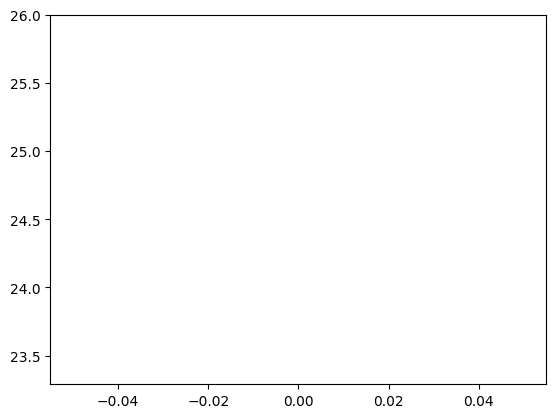

Train Epoch: 2 [0/60000 (0%)]	Loss: 24.217859,(tensor(23.9206, grad_fn=<MulBackward0>), tensor(0.0913, grad_fn=<MulBackward0>), tensor(0.2060, grad_fn=<MulBackward0>))


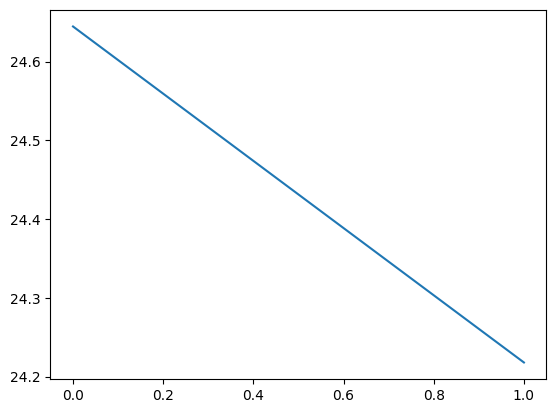

Train Epoch: 3 [0/60000 (0%)]	Loss: 24.736689,(tensor(24.4458, grad_fn=<MulBackward0>), tensor(0.0913, grad_fn=<MulBackward0>), tensor(0.1997, grad_fn=<MulBackward0>))


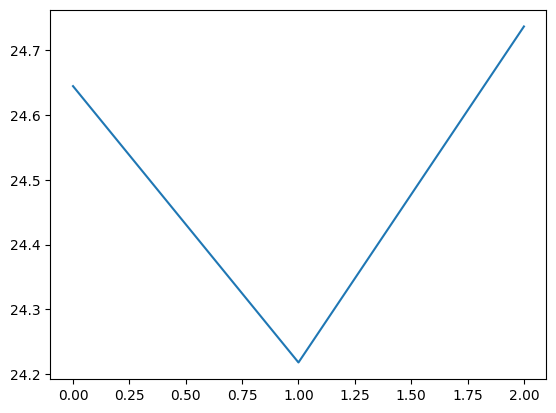

Train Epoch: 4 [0/60000 (0%)]	Loss: 24.311344,(tensor(24.0333, grad_fn=<MulBackward0>), tensor(0.0913, grad_fn=<MulBackward0>), tensor(0.1868, grad_fn=<MulBackward0>))


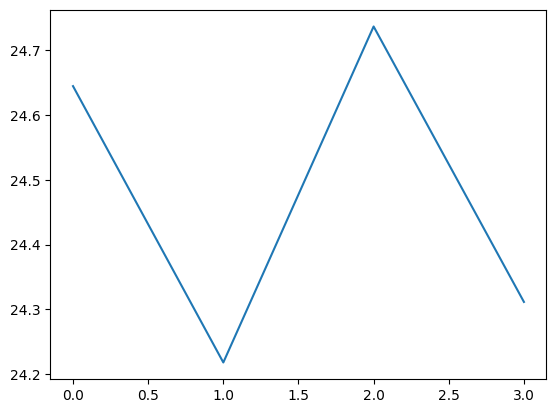

Train Epoch: 5 [0/60000 (0%)]	Loss: 24.040512,(tensor(23.7518, grad_fn=<MulBackward0>), tensor(0.0913, grad_fn=<MulBackward0>), tensor(0.1975, grad_fn=<MulBackward0>))


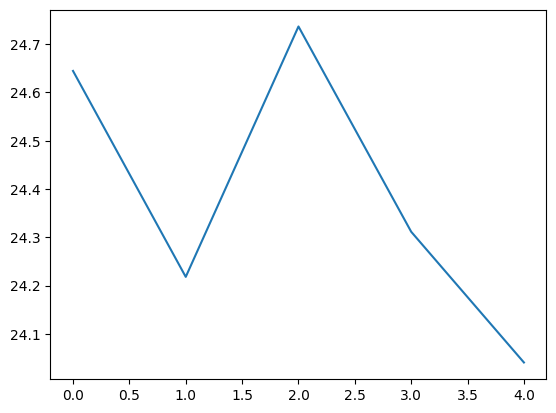

Train Epoch: 6 [0/60000 (0%)]	Loss: 24.727118,(tensor(24.4566, grad_fn=<MulBackward0>), tensor(0.0913, grad_fn=<MulBackward0>), tensor(0.1793, grad_fn=<MulBackward0>))


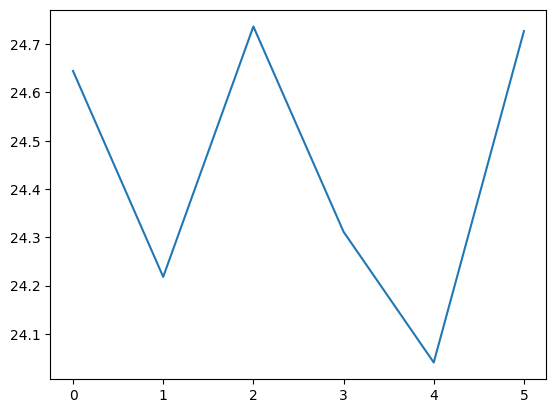

Train Epoch: 7 [0/60000 (0%)]	Loss: 23.850901,(tensor(23.5870, grad_fn=<MulBackward0>), tensor(0.0913, grad_fn=<MulBackward0>), tensor(0.1726, grad_fn=<MulBackward0>))


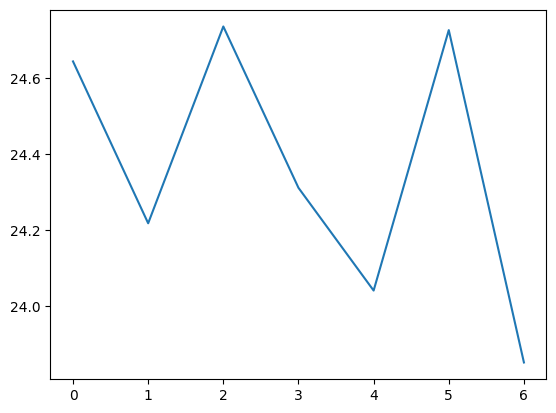

Train Epoch: 8 [0/60000 (0%)]	Loss: 25.095505,(tensor(24.8306, grad_fn=<MulBackward0>), tensor(0.0913, grad_fn=<MulBackward0>), tensor(0.1736, grad_fn=<MulBackward0>))


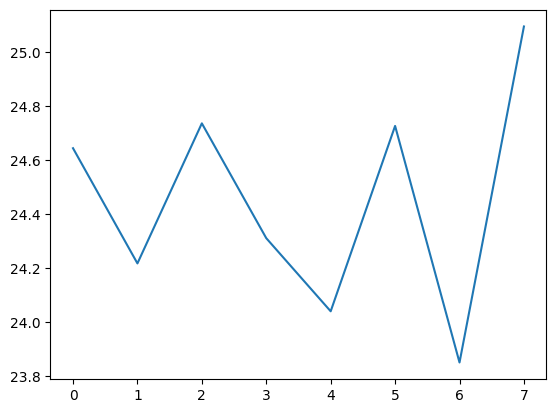

In [38]:
model=TrainVDM(512, 8)

# RECONSTRUCTION

In [42]:

VDM= VariationalDiffusion(32, 32)
VDM.load_state_dict(torch.load("./MODEL_32_512_8___128"))


<All keys matched successfully>

In [43]:
test_loader = torch.utils.data.DataLoader(
torchvision.datasets.MNIST('../', train=False, download=False,transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor()
                            ])),batch_size=1, shuffle=True)
data, target = next(iter(test_loader))


In [47]:
img=data
output=VDM.recon(img=img,t=0.9)

(1, 28, 28)

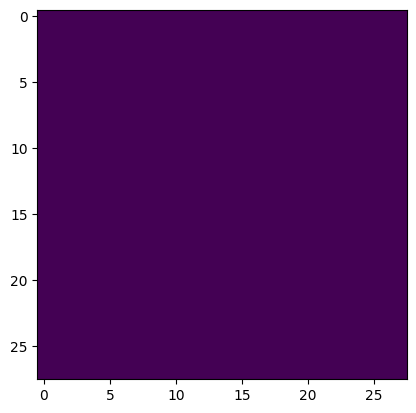

In [49]:
plt.imshow( np.transpose(output[0].detach().numpy(), (1, 2, 0)))
output[0].detach().numpy().shape

tensor(543.4274)

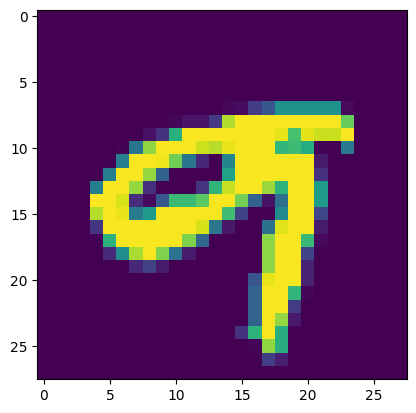

In [15]:
plt.imshow( np.transpose(img[0].detach().numpy(), (1, 2, 0)))
(torch.prod(torch.tensor(img.shape[1:]))*np.log(2))

# Old tests

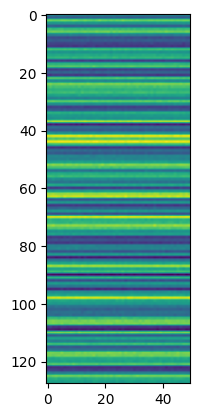

In [10]:

plt.imshow( np.transpose(VDM.encoder(torch.randn(50, 1, 28, 28)).detach().numpy()))

torch.Size([5, 1, 28, 28])
torch.Size([5, 1, 28, 28])
(tensor(0.4574), tensor(0.0003), tensor(0.8466))
tensor(0.)
torch.Size([3, 28, 28]) torch.Size([3, 28, 28])
torch.Size([3, 28, 28])


C:\Users\20210826\AppData\Local\Temp\ipykernel_12620\3071367485.py:143: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor = torch.tensor(gamma_x)


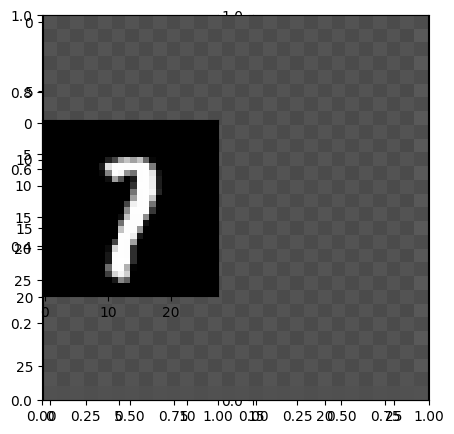

In [45]:
test_loader = torch.utils.data.DataLoader(
torchvision.datasets.MNIST('../', train=False, download=False,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor()
                            ])),batch_size=5, shuffle=True)
#(0.1307,), (0.3081,)
#tf.random.uniform(image.shape) < image / 255.0
def test(test_loader, VDM):
    #batch=torch.empty((10,1,28,28), dtype=torch.int64)
    VDM.eval()
    with torch.no_grad():
        data, target = next(iter(test_loader))
        print(data.shape)
        loss, ind_loss, output = VDM(data)
        print(output.shape)
        print(ind_loss)
        print(data[1].min())
    fig, ax = plt.subplots(1,2,figsize=(5,5))
    global img, img_in
    img=torchvision.utils.make_grid(output[:1], 1, 0)
    img_in=torchvision.utils.make_grid(data[:1], 1, 0)
    fig.add_subplot(1, 1, 1)
    print(img_in.shape, img.shape)
    plt.imshow( np.transpose(img.numpy(), (1, 2, 0)))
    print(img.shape)
    fig.add_subplot(1, 2, 1)
    plt.imshow( np.transpose(img_in.numpy(), (1, 2, 0))) 
    plt.show
test(test_loader,VDM)
#loss_recon, loss_latent, loss_diff
#loss_recon should be highest

In [129]:
test_loader = torch.utils.data.DataLoader(
torchvision.datasets.MNIST('../', train=False, download=False,transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor()
                            ])),batch_size=10, shuffle=True)
data, target = next(iter(test_loader))
data.min()

tensor(0.)